## Project 1: Predicting Exoplanets  

### David Kinney - DSC 680 - Spring 2021 - Professor Catherine Williams  

*********************************************

### Table of Contents

* [Data Preparation](#chapter1)
* [Data Wrangling](#chapter2)
* [Dimensionality Reduction](#chapter3)
    * [Reducing Features: PCA](#section_3_1)
* [TBD](#chapter4)
    * [Section 4.1](#section_4_1) 
     
****************************************************

In [2]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from pandas.plotting import scatter_matrix
from pandas_profiling import ProfileReport
from sklearn.preprocessing import LabelBinarizer, LabelBinerizer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
%matplotlib inline

In [3]:
# Read the Kepler Objects of Interest (KOI) dataset and look at one observation
df_koi = pd.read_csv('./data/cumulative_2021.03.16_17.10.21.csv')
print(df_koi.shape)
print(df_koi[1:2].T)

(9564, 141)
                                                                    1
rowid                                                               2
kepid                                                        10797460
kepoi_name                                                  K00752.02
kepler_name                                              Kepler-227 c
koi_disposition                                             CONFIRMED
koi_vet_stat                                                     Done
koi_vet_date                                                8/16/2018
koi_pdisposition                                            CANDIDATE
koi_score                                                       0.969
koi_fpflag_nt                                                       0
koi_fpflag_ss                                                       0
koi_fpflag_co                                                       0
koi_fpflag_ec                                                       0
koi_disp

***************************************************
### Data Preparation <a class="anchor" id="chapter2"></a>

* Identify and remove all empty columns and columns containing only 0.  
* In addition, I decided to remove all "err1" and "err2" columns. I *suspect* they have minimal impact and removing them will further reduce the feature set.

In [4]:
# Remove variables with no data
df_koi_cleaned = df_koi.dropna(axis=1, how='all')

# Remove columns containing only zero
df_koi_cleaned = df_koi_cleaned.loc[:, (df_koi_cleaned != 0).any(axis=0)]

# Remove the err columns
df_koi_cleaned = df_koi_cleaned[df_koi_cleaned.columns.drop(
    list(df_koi_cleaned.filter(regex='_err')))]

In [5]:
# Still some variables that are all 0.0; will just drop them manually...
cols = ['koi_eccen','koi_ldm_coeff4','koi_ldm_coeff3']
df_koi_cleaned = df_koi_cleaned.drop(cols,axis=1)
df_koi_cleaned.shape

(9564, 75)

In [6]:
df_describe = pd.DataFrame(df_koi_cleaned.describe())
df_describe

,rowid,kepid,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_time0,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,koi_teq,koi_insol,koi_dor,koi_ldm_coeff2,koi_ldm_coeff1,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_quarters,koi_bin_oedp_sig,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass,ra,dec,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sdec,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
count,9564.000000,9.564000e+03,8054.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9.564000e+03,9201.000000,9564.000000,9.201000e+03,9201.000000,9243.000000,9201.000000,9201.000000,9200.000000,9201.000000,9.243000e+03,9201.000000,9201.000000,9201.000000,8422.000000,8422.000000,9201.000000,9564.000000,8422.000000,9218.000000,8.422000e+03,8054.000000,9201.000000,9201.000000,9178.000000,9201.000000,9201.000000,9564.000000,9564.000000,9563.000000,9523.000000,9555.000000,9410.000000,8951.000000,9539.000000,9539.000000,9539.00000,8488.000000,9058.000000,9058.000000,9109.000000,9109.000000,8734.000000,8747.000000,8965.000000,8965.000000,8965.000000,8994.000000,8994.000000,8994.000000
mean,4782.500000,7.690628e+06,0.480829,0.208595,0.232748,0.197512,0.120033,75.671358,166.183251,2.454999e+06,0.735105,5.621606,2.379245e+04,0.283646,9.164414,102.891778,0.223989,82.469147,1085.385828,7.745737e+03,76.736333,0.254439,0.407617,176.846052,1025.664672,259.895001,1.406315,385.006768,1.243654,9.151387e+30,0.409500,5706.823280,4.310157,-0.124431,1.728712,1.023706,292.060163,43.810433,14.264606,14.830501,14.221565,14.075138,13.991724,12.993311,12.620604,12.54341,0.150994,19.471356,43.829239,-0.316136,-0.165817,-0.000097,-0.000714,-0.012281,-0.045420,1.866561,-0.024244,-0.076749,1.812566
std,2761.033321,2.653459e+06,0.476928,4.767290,0.422605,0.398142,0.325018,1334.744046,67.918960,6.791896e+01,3.348832,6.471554,8.224316e+04,3.306558,53.807967,3077.639126,0.566359,15.223627,856.351161,1.592047e+05,845.274598,0.064806,0.106076,770.902357,4154.121620,795.806615,0.873289,545.756200,0.664573,4.153749e+30,0.500793,796.857947,0.432606,0.282111,6.127185,0.349447,4.766657,3.601243,1.385448,1.501885,1.383713,1.292573,1.230351,1.291912,1.267215,1.26818,0.252648,0.319158,3.599553,20.254777,20.534655,0.058225,0.092987,2.406550,2.573558,2.988742,2.382286,2.553758,2.986376
min,1.000000,7.574500e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.241843,120.515914,2.454954e+06,0.000000,0.052000,0.000000e+00,0.001289,0.000040,0.080000,0.005900,2.290000,25.000000,0.000000e+00,0.373000,-0.120600,0.125400,2.417437,7.105086,0.000000,1.000000,0.000000,1.000000,1.000000e+15,-1.000000,2661.000000,0.047000,-2.500000,0.109000,0.000000,279.852720,36.577381,6.966000,7.225000,7.101000,7.627000,6.702000,4.097000,3.014000,2.31100,0.000000,18.657036,36.576888,-742.430000,-417.900000,-4.000000,-6.000000,-25.100000,-75.900000,0.000000,-27.800000,-76.600000,0.000000
25%,2391.750000,5.556034e+06,0.000000,0.000000,0.000000,0.000000,0.000000,2.733684,132.761718,2.454966e+06,0.197000,2.437750,1.600000e+02,0.012341,0.229250,1.400000,0.037700,83.920000,539.000000,2.015000e+01,5.358000,0.228600,0.326800,3.997856,10.733030,12.000000,1.000000,41.000000,1.000000,1.111100e+31,0.134650,5310.000000,4.218000,-0.260000,0.829000,0.845000,288.660770,40.777173,13.440000,13.896500,13.393000,13.294000,13.276000,12.253000,11.914500,11.84300,0.000000,19.243889,40.798688,-0.600000,-0.680000,-0.000210,-0.000220,-0.320000,-0.387000,0.170000,-0.310000,-0.390000,0.210000
50%,4782.500000,7.906892e+06,0.334000,0.000000,0.000000,0.000000,0.000000,9.752831,137.224595,2.454970e+06,0.537000,3.792600,4.210000e+02,0.021076,0.956720,2.390000,0.085100,88.500000,878.000000,1.416000e+02,15.460000,0.271100,0.392000,5.589751

The **Kepler Objects of Interest (KOI)** dataset contains eight categories of variables. The first three categories--Identification, Exoplanet Archive Information and Project Disposition--are descriptive. The remaining five are measures used to identify an object as an exoplanet.

* Transit Properties  
* Threshold-Crossing Event (TCE) Information  
* Stellar Parameters  
* KIC Parameters  
* Pixel-Based KOI Vetting Statistics

I am breaking up the dataset into subsets based on category to make exploratory analysis a little simpler and easier to manage.

In [8]:
transit_columns = ['koi_period', 'koi_time0bk', 'koi_time0', 'koi_impact', 
                   'koi_duration', 'koi_depth', 'koi_ror', 'koi_srho', 'koi_fittype', 
                   'koi_prad', 'koi_sma', 'koi_incl', 'koi_teq', 'koi_insol', 'koi_dor', 
                   'koi_limbdark_mod', 'koi_ldm_coeff2', 'koi_ldm_coeff1', 'koi_parm_prov']
tce_columns = ['koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_count', 
               'koi_num_transits', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_quarters', 
               'koi_trans_mod', 'koi_datalink_dvr', 'koi_datalink_dvs']
stellar_columns = ['koi_steff', 'koi_slogg', 'koi_smet', 'koi_srad', 'koi_smass', 'koi_sparprov']
kic_columns = ['ra', 'dec', 'koi_kepmag', 'koi_gmag', 'koi_rmag', 'koi_imag', 'koi_zmag', 
               'koi_jmag', 'koi_hmag', 'koi_kmag']
pixel_columns = ['koi_fwm_sra', 'koi_fwm_sdec', 'koi_fwm_srao', 'koi_fwm_sdeco', 'koi_fwm_prao', 
                 'koi_fwm_pdeco', 'koi_fwm_stat_sig', 'koi_dicco_mra', 'koi_dicco_mdec', 
                 'koi_dicco_msky', 'koi_dikco_mra', 'koi_dikco_mdec', 'koi_dikco_msky']


df_transit = df_koi_cleaned[transit_columns]
df_tce = df_koi_cleaned[tce_columns]
df_stellar = df_koi_cleaned[stellar_columns]
df_kic = df_koi_cleaned[kic_columns]
df_pixel = df_koi_cleaned[pixel_columns]

In [10]:
# The pandas-profiling package is generating a SettingWithCopyWarning over which
# I have no control.
import warnings
warnings.simplefilter(action='ignore')

profile = ProfileReport(df_transit, title="Pandas Profiling Report")
# profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)

In [12]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
profile.to_file("profile_report.html")

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### Transit variables

In [23]:
"""
The 3 categorical variables did not display much variation. In fact, koi_limbdark_mod 
was a constant value while koi_fittype and koi_parm_prov had a constant value in 
roughly 80% of the observations.
"""
cat_cols = ['koi_limbdark_mod', 'koi_fittype', 'koi_parm_prov']
df_transit = df_transit.drop(cat_cols, axis=1)

In [ ]:
df_transit.hist(bins=50, figsize=[20,15])

In [ ]:
box, ax = plt.subplots()
ax = sns.boxplot(x='koi_disposition', y='koi_period', data=df_koi_cleaned)
plt.show()

In [ ]:
df_temp = pd.concat([df_koi['koi_disposition'], df_transit], axis=1)
facet = sns.FacetGrid(df_temp,col='koi_disposition')
facet.map(sns.boxplot)

*********************************
### Dimensionality Reduction <a class="anchor" id="chapter3"></a>

#### Reducing Features using Principal Components Analysis (PCA) <a class="anchor" id="section_3_1"></a>

I am going to take two passes at **Dimensionality Reduction** by first creating sub-datasets by category and applying `PCA` to each, merging the results back into one dataset, and then applying `PCA` to the (hopefully) reduced dataset.

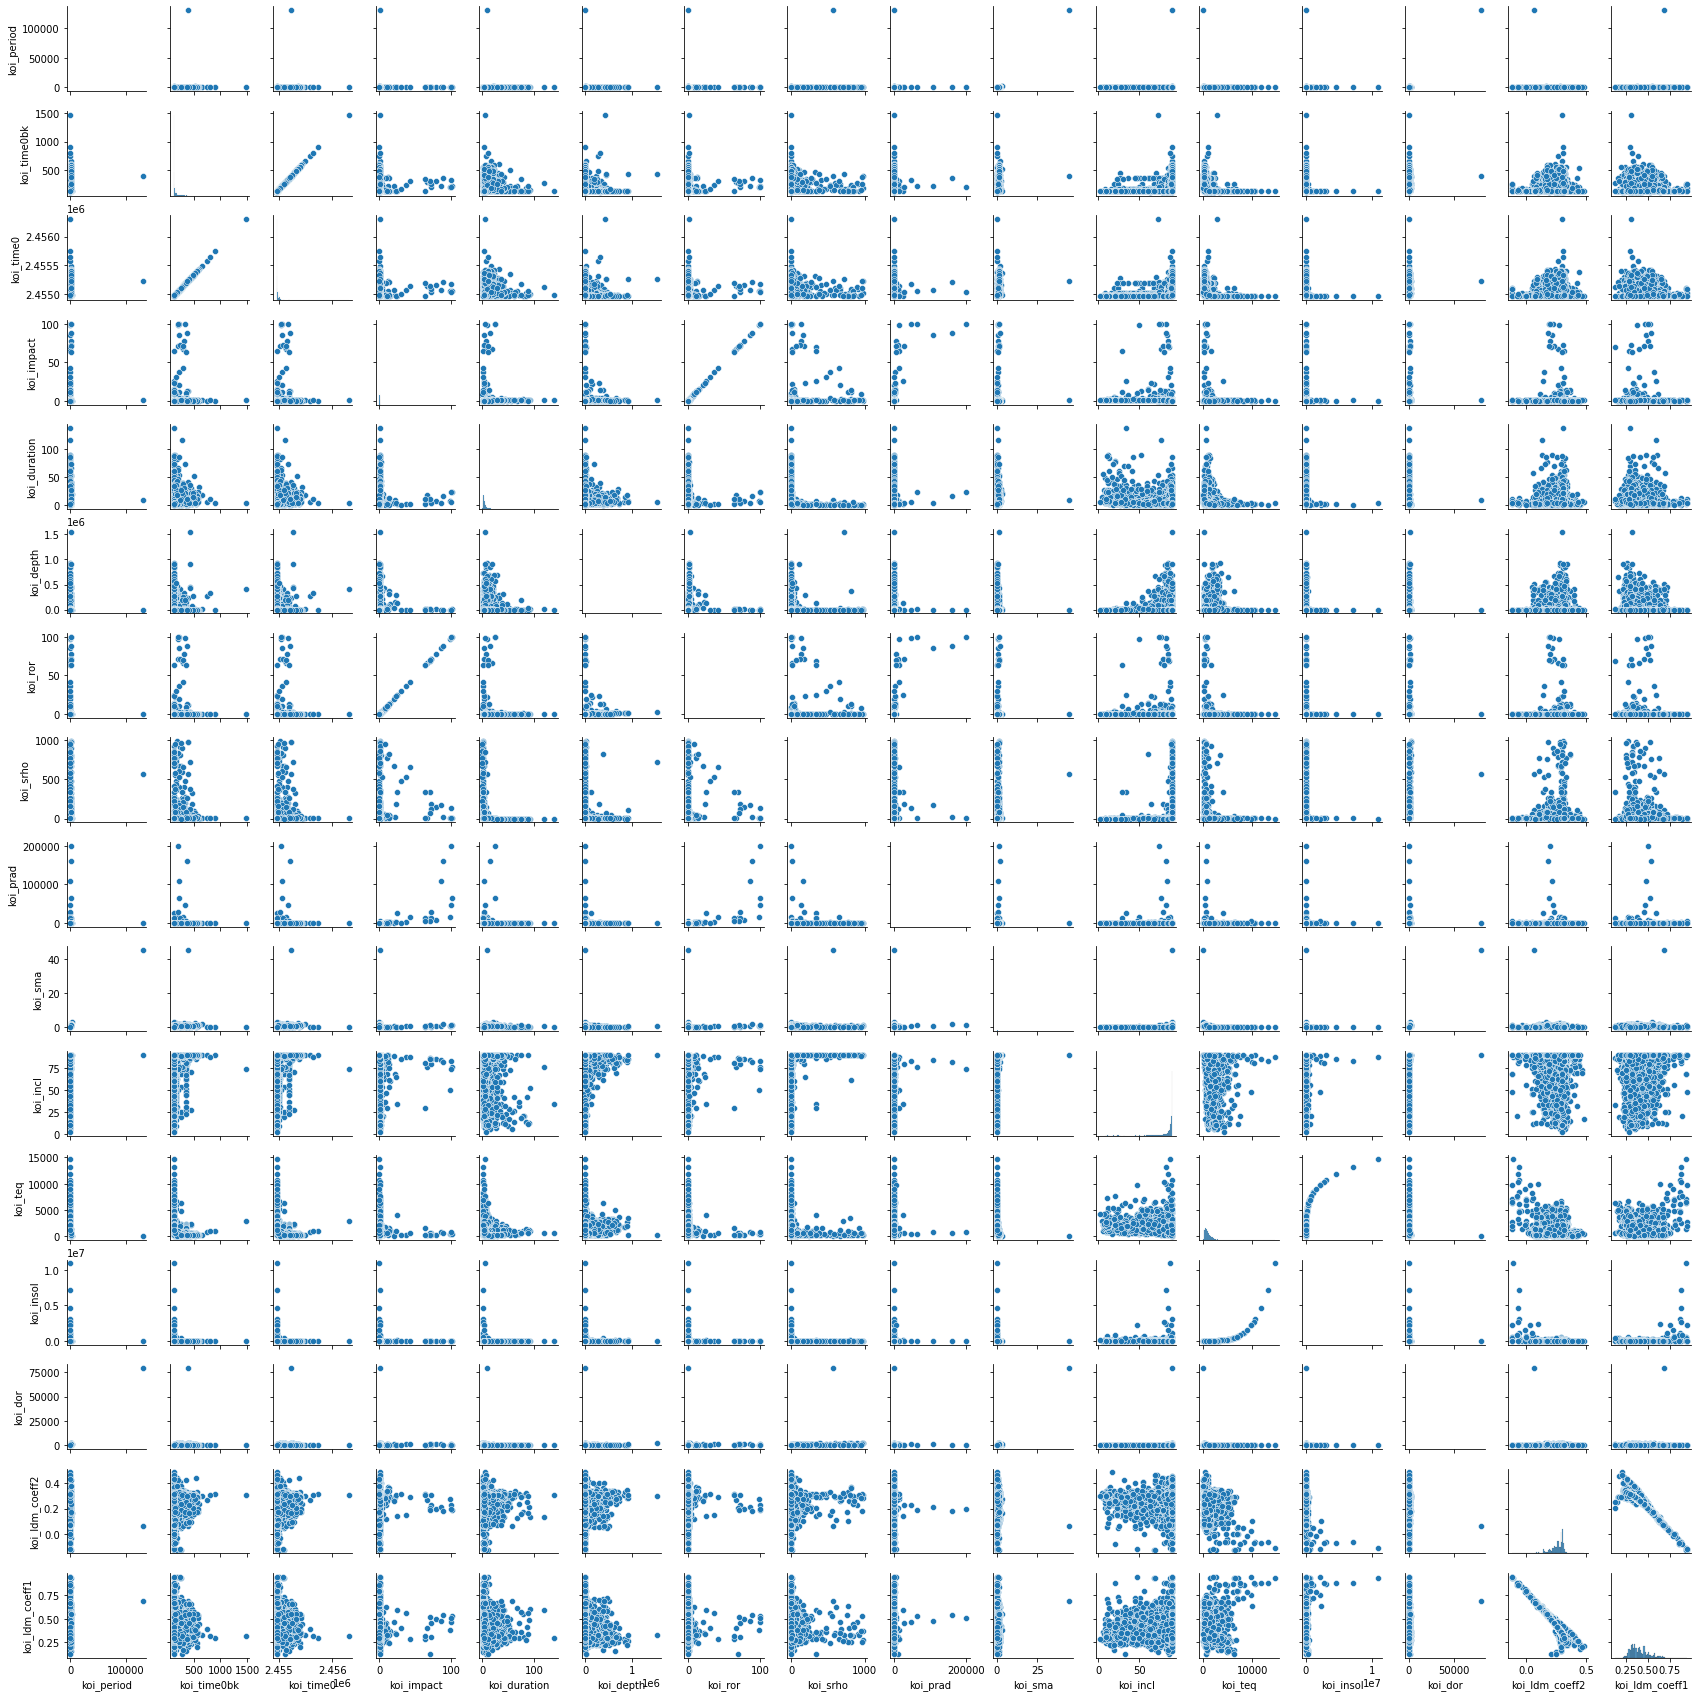

In [24]:
sns.pairplot(df_transit,height=1.5)

In [14]:
# Load libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [18]:
# PCA function
def pca(df):
    
    # standardize the features matrix
    features = StandardScaler().fit_transform(df)
    
    # Create a PCA that retains 99% of the variance
    pca = PCA(n_components = 0.99, whitten=True, svd_solver='randomized')
    features_pca = pca.fit_transform(features)
    
    return features, features_pca

In [19]:
features, features_pca = pca(df_transit)
print('Original number of features: {}'.format(features.shape[1]))
print('Reduced number of features: {}'.format(features_pca.shape[1]))

ValueError: could not convert string to float: 'LS+MCMC'

*****************************
### TBD <a class="anchor" id="chapter4"></a>




##### Section 1.2.1 <a class="anchor" id="section_1_2_1"></a>

##### Section 1.2.2 <a class="anchor" id="section_1_2_2"></a>

##### Section 1.2.3 <a class="anchor" id="section_1_2_3"></a>



#### Section 2.1 <a class="anchor" id="section_2_1"></a>

#### Section 2.2 <a class="anchor" id="section_2_2"></a>